# Imports

In [101]:
import gzip
import pandas as pd
import contractions
import string
import re
from sklearn.model_selection import train_test_split
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_score, recall_score, f1_score
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import matplotlib.pyplot as plt

# 1) Dataset Generation

##### For preparing the data, I am using the gzip package to open and read the dataset. The datasets consists of 15 columns of which I am extracting the 'review_body' and 'rating' column for this assignment. The dataframe 'df_review_rating' holds these extracted columns. I am converting the 'ratings' to a standard format which I am then using to create our binary classes. For simplicity, I have created a copy of the 'df_review_rating' called 'binary_df' which has an extra column called as 'classes'. This columns holds the labels for our dataset. Finally, I extracted 50000 reviews randomly from each class and stored it in the 'dataset_df' dataset

### Read Data

In [9]:
dataset_path = 'amazon_reviews_us_Office_Products_v1_00.tsv.gz'
with gzip.open(dataset_path, 'rt', encoding='utf-8') as file:
    df = pd.read_csv(file, sep='\t', on_bad_lines='skip', low_memory=False)

In [10]:
print(df.columns.values)
df.head(5)

['marketplace' 'customer_id' 'review_id' 'product_id' 'product_parent'
 'product_title' 'product_category' 'star_rating' 'helpful_votes'
 'total_votes' 'vine' 'verified_purchase' 'review_headline' 'review_body'
 'review_date']


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,43081963,R18RVCKGH1SSI9,B001BM2MAC,307809868,"Scotch Cushion Wrap 7961, 12 Inches x 100 Feet",Office Products,5,0.0,0.0,N,Y,Five Stars,Great product.,2015-08-31
1,US,10951564,R3L4L6LW1PUOFY,B00DZYEXPQ,75004341,"Dust-Off Compressed Gas Duster, Pack of 4",Office Products,5,0.0,1.0,N,Y,"Phffffffft, Phfffffft. Lots of air, and it's C...",What's to say about this commodity item except...,2015-08-31
2,US,21143145,R2J8AWXWTDX2TF,B00RTMUHDW,529689027,Amram Tagger Standard Tag Attaching Tagging Gu...,Office Products,5,0.0,0.0,N,Y,but I am sure I will like it.,"Haven't used yet, but I am sure I will like it.",2015-08-31
3,US,52782374,R1PR37BR7G3M6A,B00D7H8XB6,868449945,AmazonBasics 12-Sheet High-Security Micro-Cut ...,Office Products,1,2.0,3.0,N,Y,and the shredder was dirty and the bin was par...,Although this was labeled as &#34;new&#34; the...,2015-08-31
4,US,24045652,R3BDDDZMZBZDPU,B001XCWP34,33521401,"Derwent Colored Pencils, Inktense Ink Pencils,...",Office Products,4,0.0,0.0,N,Y,Four Stars,Gorgeous colors and easy to use,2015-08-31


### Keep Reviews and Ratings

In [11]:
df_review_rating = df[['star_rating','review_body']]
df_review_rating

,star_rating,review_body
0,5,Great product.
1,5,What's to say about this commodity item except...
2,5,"Haven't used yet, but I am sure I will like it."
3,1,Although this was labeled as &#34;new&#34; the...
4,4,Gorgeous colors and easy to use
...,...,...
2640249,4,I can't live anymore whithout my Palm III. But...
2640250,4,Although the Palm Pilot is thin and compact it...
2640251,4,This book had a lot of great content without b...
2640252,5,I am teaching a course in Excel and am using t...


In [12]:
df_review_rating['star_rating']=pd.to_numeric(df_review_rating['star_rating'], errors='coerce')
df_review_rating = df_review_rating[pd.notna(df_review_rating['star_rating'])]

df_review_rating.head(5)

C:\Users\YASH\AppData\Local\Temp\ipykernel_23716\2485622692.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_review_rating['star_rating']=pd.to_numeric(df_review_rating['star_rating'], errors='coerce')


,star_rating,review_body
0,5.0,Great product.
1,5.0,What's to say about this commodity item except...
2,5.0,"Haven't used yet, but I am sure I will like it."
3,1.0,Although this was labeled as &#34;new&#34; the...
4,4.0,Gorgeous colors and easy to use


 ### We form two classes and select 50000 reviews randomly from each class.



In [13]:
df_review_rating['star_rating'].unique()

array([5., 1., 4., 2., 3.])

In [14]:
binary_df = df_review_rating.copy()

def category(row):
    if row['star_rating'] == 1 or row['star_rating'] == '1' or row['star_rating'] == 2 or row['star_rating'] == '2' or row['star_rating'] == 3 or row['star_rating'] == '3':
        return 1
    
    else:
        return 2

In [15]:
binary_df['class'] = df.apply(lambda row: category(row), axis=1)
binary_df

,star_rating,review_body,class
0,5.0,Great product.,2
1,5.0,What's to say about this commodity item except...,2
2,5.0,"Haven't used yet, but I am sure I will like it.",2
3,1.0,Although this was labeled as &#34;new&#34; the...,1
4,4.0,Gorgeous colors and easy to use,2
...,...,...,...
2640249,4.0,I can't live anymore whithout my Palm III. But...,2
2640250,4.0,Although the Palm Pilot is thin and compact it...,2
2640251,4.0,This book had a lot of great content without b...,2
2640252,5.0,I am teaching a course in Excel and am using t...,2


In [16]:
print(binary_df['class'].value_counts())
print(binary_df['class'].unique())

2    2001183
1     639054
Name: class, dtype: int64
[2 1]


In [17]:
# Reading rows belonging to classes 1 and 2
class1_df = binary_df[binary_df['class'] == 1]
class2_df = binary_df[binary_df['class'] == 2]

# Randomly choosing 50,000 reviews of each class
random_class1_df = class1_df.sample(n = 50000, random_state=42)
random_class2_df = class2_df.sample(n = 50000, random_state=42)

# Combining the two classes to create a single dataset
dataset_df = pd.concat([random_class1_df, random_class2_df])

# Reset the indexes
dataset_df.reset_index(drop=True, inplace=True)

dataset_df

,star_rating,review_body,class
0,1.0,it says right in the specifications that it wo...,1
1,1.0,These things were horrible. Used 6 to hang a ...,1
2,2.0,"Not sure why, but works for one Epson printer ...",1
3,1.0,I ordered two letter organizers and received t...,1
4,3.0,"This kit comes with 5 gears, 4 of which go int...",1
...,...,...,...
99995,5.0,I BUY THIS EVERY YEAR.,2
99996,5.0,Good shredder at a good price.,2
99997,5.0,We have actually had this system for almost 5 ...,2
99998,5.0,Awesome!! Work and print just like the origina...,2


In [18]:
dataset_df['class'].astype(int)
dataset_df['class'].value_counts()

1    50000
2    50000
Name: class, dtype: int64

#### Data Cleaning

#### The following tasks were performed for cleaning the dataset - 
#### 1) Firstly, I looked for rows with missed values and replaced it with an empty string.
#### 2) Converted all the reviews to lowercase using the lower() function.
#### 3) Removed punctuations from the review by using the string.punctuation package.
#### 4) Removed any kind of non-alphabetical characters from the reviews by tokenizing the words and checking if each character is between A-Z or a-z.
#### 5) Removed all HTML tags and URLs from the reviews.
#### 6) Removed any use of emojis in the reviews.
#### 7) Finally, removed all the extra spaces from the reviews.

#### I performed contractions on the reviews as well. However, I got slightly better results when contractions was avoided.


In [19]:
print(dataset_df.isnull().values.any())
print(dataset_df.isnull().sum())

dataset_df = dataset_df.fillna('')

True
star_rating    0
review_body    1
class          0
dtype: int64


### Storing average length of the reviews in terms of character length in your dataset before cleaning

In [20]:
reviewLen = pd.DataFrame()
reviewLen['before'] = dataset_df['review_body'].str.len()
print(reviewLen.head(5))

   before
0     174
1     335
2     109
3     355
4     427


### Converting reviews into lowercase

In [21]:
dataset_df['review_body'] = dataset_df['review_body'].str.lower()
reviewLen['lowercase'] = dataset_df['review_body'].str.len()
print(dataset_df.head(5))

   star_rating                                        review_body  class
0          1.0  it says right in the specifications that it wo...      1
1          1.0  these things were horrible.  used 6 to hang a ...      1
2          2.0  not sure why, but works for one epson printer ...      1
3          1.0  i ordered two letter organizers and received t...      1
4          3.0  this kit comes with 5 gears, 4 of which go int...      1


### Remove Punctuations

In [22]:
def remove_punctuations(text):
    if isinstance(text, str): 
        return ''.join(char for char in text if char not in string.punctuation)
    else:
        return text

dataset_df['review_body'] = dataset_df['review_body'].apply(remove_punctuations)
reviewLen['punctations'] = dataset_df['review_body'].str.len()

print(dataset_df.head(5))

   star_rating                                        review_body  class
0          1.0  it says right in the specifications that it wo...      1
1          1.0  these things were horrible  used 6 to hang a s...      1
2          2.0  not sure why but works for one epson printer b...      1
3          1.0  i ordered two letter organizers and received t...      1
4          3.0  this kit comes with 5 gears 4 of which go into...      1


### Remove non-alphabetical characters

In [23]:
def remove_non_alphabetical(text):
    if isinstance(text, str): 
        return re.sub(r'[^a-zA-Z]', ' ', text)
    else:
        return text

dataset_df['review_body'] = dataset_df['review_body'].apply(remove_non_alphabetical)
reviewLen['non_alphanum'] = dataset_df['review_body'].str.len()

print(dataset_df.head(5))

   star_rating                                        review_body  class
0          1.0  it says right in the specifications that it wo...      1
1          1.0  these things were horrible  used   to hang a s...      1
2          2.0  not sure why but works for one epson printer b...      1
3          1.0  i ordered two letter organizers and received t...      1
4          3.0  this kit comes with   gears   of which go into...      1


### Remove HTML and URLs from the reviews

In [24]:
dataset_df['review_body'] = dataset_df['review_body'].astype(str)

def remove_html_tags(text):
    try:
        clean_text = re.sub(r'<.*?>', '', text)
        return clean_text
    except TypeError:
        return text

def remove_urls(text):
    try:
        clean_text = re.sub(r'http\S+', '', text)
        return clean_text
    except TypeError:
        return text

dataset_df['review_body'] = dataset_df['review_body'].apply(remove_html_tags)
dataset_df['review_body'] = dataset_df['review_body'].apply(remove_urls)

reviewLen['HTML_URLs'] = dataset_df['review_body'].str.len()

print(dataset_df.head(5))

   star_rating                                        review_body  class
0          1.0  it says right in the specifications that it wo...      1
1          1.0  these things were horrible  used   to hang a s...      1
2          2.0  not sure why but works for one epson printer b...      1
3          1.0  i ordered two letter organizers and received t...      1
4          3.0  this kit comes with   gears   of which go into...      1


### Remove Emojis

In [25]:

def remove_emojis(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', text)

dataset_df['review_body'] = dataset_df['review_body'].apply(remove_emojis)
reviewLen['Emojis'] = dataset_df['review_body'].str.len()

print(dataset_df.head(5))

   star_rating                                        review_body  class
0          1.0  it says right in the specifications that it wo...      1
1          1.0  these things were horrible  used   to hang a s...      1
2          2.0  not sure why but works for one epson printer b...      1
3          1.0  i ordered two letter organizers and received t...      1
4          3.0  this kit comes with   gears   of which go into...      1


### Remove extra spaces

In [26]:
dataset_df['review_body'] = dataset_df['review_body'].str.replace(r'\s+', ' ', regex=False)
reviewLen['extraSpaces'] = dataset_df['review_body'].str.len()

print(dataset_df.head(5))

   star_rating                                        review_body  class
0          1.0  it says right in the specifications that it wo...      1
1          1.0  these things were horrible  used   to hang a s...      1
2          2.0  not sure why but works for one epson printer b...      1
3          1.0  i ordered two letter organizers and received t...      1
4          3.0  this kit comes with   gears   of which go into...      1


### Average length of the reviews in terms of character length in your dataset before and after cleaning

In [28]:
reviewLen['after'] = dataset_df['review_body'].str.len()

print("The average length of the reviews before clearning - ",reviewLen['before'].mean())
print("The average length of the reviews after cleaning - ", reviewLen['after'].mean())

The average length of the reviews before clearning -  316.02996
The average length of the reviews after cleaning -  304.46909


# 2) Word Embedding

### 2-a) Load the pretrained “word2vec-google-news-300” Word2Vec model and learn how to extract word embeddings for your dataset. Try to check semantic similarities of the generated vectors using three examples of your own, e.g., King − Man + Woman = Queen or excellent ∼ outstanding.

In [29]:
# Splitting the Dataset

Xtrain, Xtest, Ytrain, Ytest = train_test_split(dataset_df['review_body'], dataset_df['class'], test_size=0.2, random_state=16)
print("Training Shape ", Xtrain.shape)
print("Testing Shape ", Xtest.shape)

Training Shape  (80000,)
Testing Shape  (20000,)


In [102]:
# Load the Word2Vec google model
w2v_model = api.load('word2vec-google-news-300')

In [117]:
# Calculate most similarity
print(w2v_model.most_similar(positive=['king','woman'], negative=['man']))
print(w2v_model.most_similar('excellent'))
print(w2v_model.most_similar(positive=['she','father'], negative=['him']))
print(w2v_model.most_similar('happy'))

[('queen', 0.7118193507194519), ('monarch', 0.6189674139022827), ('princess', 0.5902431011199951), ('crown_prince', 0.5499460697174072), ('prince', 0.5377321839332581), ('kings', 0.5236844420433044), ('Queen_Consort', 0.5235945582389832), ('queens', 0.5181134343147278), ('sultan', 0.5098593831062317), ('monarchy', 0.5087411999702454)]
[('terrific', 0.7409726977348328), ('superb', 0.7062715888023376), ('exceptional', 0.681470513343811), ('fantastic', 0.6802847981452942), ('good', 0.6442928910255432), ('great', 0.6124600172042847), ('Excellent', 0.6091997623443604), ('impeccable', 0.5980967283248901), ('exemplary', 0.5959650278091431), ('marvelous', 0.582928478717804)]
[('mother', 0.7119967341423035), ('husband', 0.6427904963493347), ('daughter', 0.6421711444854736), ('sister', 0.6059560179710388), ('eldest_daughter', 0.5988065004348755), ('grandmother', 0.5926641225814819), ('mom', 0.5790746212005615), ('aunt', 0.5724061131477356), ('niece', 0.555463969707489), ('granddaughter', 0.55174

In [32]:
# Calculate cosine similarity
print(cosine_similarity([w2v_model['he']], [w2v_model['she']]))
print(cosine_similarity([w2v_model['excellent']],[w2v_model['outstanding']]))
print(cosine_similarity([w2v_model['him']], [w2v_model['father'] - w2v_model['she']]))

[[0.61299497]]
[[0.5567486]]
[[0.0734347]]


### 2-b) Train a Word2Vec model using your own dataset. You will use these extracted features in the subsequent questions of this assignment. Set the embedding size to be 300 and the window size to be 13. You can also consider a minimum word count of 9. Check the semantic similarities for the same two examples in part (a). What do you conclude from comparing vectors generated by yourself and the pretrained model? Which of the Word2Vec models seems to encode semantic similarities between words better? For the rest of this assignment, use the pretrained “word2vec-googlenews-300” Word2Ve features.

In [104]:
Xtrain_words = list(Xtrain.str.split(" "))
model = Word2Vec(Xtrain_words, vector_size=300, window=13, min_count=9)
model.save("custom_word2vec.model")

In [115]:
print(model.wv.most_similar(positive=['king','woman'], negative=['man']))
print(model.wv.most_similar(positive = ['excellent']))
print(model.wv.most_similar(positive=['she','father'], negative=['him']))
print(model.wv.most_similar('happy'))

[('league', 0.6516976356506348), ('padfolio', 0.605780303478241), ('bible', 0.5874396562576294), ('fiber', 0.5822516083717346), ('knuckle', 0.5762327313423157), ('portfolio', 0.5746113061904907), ('sword', 0.5739806890487671), ('antiglare', 0.5703129172325134), ('filofax', 0.5691536664962769), ('ergo', 0.5683412551879883)]
[('outstanding', 0.8251203298568726), ('exceptional', 0.8103826642036438), ('superb', 0.7469307780265808), ('incredible', 0.7324579358100891), ('terrific', 0.7177923917770386), ('amazing', 0.7176928520202637), ('fantastic', 0.7170583009719849), ('awesome', 0.692162036895752), ('affordable', 0.6837301254272461), ('great', 0.6481202244758606)]
[('wife', 0.6897209286689758), ('granddaughter', 0.6702401638031006), ('mom', 0.6675980091094971), ('daughter', 0.651307225227356), ('son', 0.6474236845970154), ('mother', 0.6380146145820618), ('girlfriend', 0.6181607842445374), ('dad', 0.610023021697998), ('husband', 0.598183274269104), ('coworker', 0.590136706829071)]
[('please

In [113]:
print(cosine_similarity([model.wv['he']], [model.wv['she']]))
print(cosine_similarity([model.wv['excellent']],[model.wv['outstanding']]))
print(cosine_similarity([model.wv['him']], [model.wv['father'] - model.wv['she']]))

[[0.84833896]]
[[0.82512033]]
[[-0.65903854]]


# 3) Simple models

### Generate Scores

In [35]:
def get_stats(Ytest, pred):
    precision = precision_score(Ytest, pred)
    recall = recall_score(Ytest, pred)
    f1 = f1_score(Ytest, pred)

    return precision, recall, f1

### Word2Vec

In [36]:
Word2Vec_dim = 300

# Generate average Word2Vec
def get_avg_word2vec(review, model):
    words = review.split()
    words_vector = [model[word] for word in words if word in model]
    if words_vector:
        return np.mean(words_vector, axis=0)
    else:
        return np.zeros(Word2Vec_dim)

Xtrain_wv = np.array([get_avg_word2vec(review, w2v_model) for review in Xtrain])
Xtest_wv = np.array([get_avg_word2vec(review, w2v_model) for review in Xtest])
Ytrain_wv = Ytrain.copy()
Ytest_wv = Ytest.copy()

print(Xtrain_wv.shape, Xtest_wv.shape, Ytrain_wv.shape, Ytest_wv.shape)

(80000, 300) (20000, 300) (80000,) (20000,)


In [37]:
# Initialize the Perceptron model
model_perceptron = Perceptron(alpha=0.001, max_iter=1000)

model_perceptron = model_perceptron.fit(Xtrain_wv, Ytrain_wv)
predPerceptron = model_perceptron.predict(Xtest_wv)

precisionPerceptron_wv, recallPerceptron_wv, f1Perceptron_wv = get_stats(Ytest_wv, predPerceptron)

In [38]:
model_svm = LinearSVC(C=0.35,
    tol=0.001,
    max_iter=5000,                 #Total iterations
    random_state=16,                #Control the random number generation to control the shuffling
    penalty='l1',                  #Norm of Penalty 
    class_weight="balanced",       #Provides the weight to each class
    loss='squared_hinge',          #Specifies the Loss Function
    dual=False
)

model_svm = model_svm.fit(Xtrain_wv , Ytrain_wv)
predSVM = model_svm.predict(Xtest_wv)

precisionSVM_wv, recallSVM_wv, f1SVM_wv = get_stats(Ytest_wv, predSVM)

### TF-IDF

In [39]:
tf_idf = TfidfVectorizer()
Xtrain_tf_idf = tf_idf.fit_transform(Xtrain)
Xtest_tf_idf = tf_idf.transform(Xtest)
Ytrain_tf_idf = Ytrain.copy()
Ytest_tf_idf = Ytest.copy()

print(Xtrain_tf_idf.shape, Xtest_tf_idf.shape, Ytrain_tf_idf.shape, Ytest_tf_idf.shape)

(80000, 61201) (20000, 61201) (80000,) (20000,)


In [40]:
# Initialize the Perceptron model
model_perceptron = Perceptron(alpha=0.001, max_iter=1000)

model_perceptron = model_perceptron.fit(Xtrain_tf_idf, Ytrain_tf_idf)
predPerceptron = model_perceptron.predict(Xtest_tf_idf)

precisionPerceptron_tfidf, recallPerceptron_tfidf, f1Perceptron_tfidf = get_stats(Ytest_tf_idf, predPerceptron)

In [41]:
model_svm = LinearSVC(C=0.35,
    tol=0.001,
    max_iter=1000,                 #Total iterations
    random_state=16,                #Control the random number generation to control the shuffling
    penalty='l1',                  #Norm of Penalty 
    class_weight="balanced",       #Provides the weight to each class
    loss='squared_hinge',          #Specifies the Loss Function
    dual=False
)

model_svm = model_svm.fit(Xtrain_tf_idf , Ytrain_tf_idf)
predSVM = model_svm.predict(Xtest_tf_idf)

precisionSVM_tfidf, recallSVM_tfidf, f1SVM_tfidf = get_stats(Ytest_tf_idf, predSVM)

### Results

In [42]:
print(f"Word2Vec FOR Perceptron - {precisionPerceptron_wv}, {recallPerceptron_wv}, {f1Perceptron_wv}")
print(f"Word2Vec FOR SVM - {precisionSVM_wv}, {recallSVM_wv}, {f1SVM_wv}")
print(f"TF-IDF FOR PERCEPTRON - {precisionPerceptron_tfidf}, {recallPerceptron_tfidf}, {f1Perceptron_tfidf}")
print(f"TF-IDF FOR SVM - {precisionSVM_tfidf}, {recallSVM_tfidf}, {f1SVM_tfidf}")

Word2Vec FOR Perceptron - 0.7465573770491803, 0.900355871886121, 0.8162753181573759
Word2Vec FOR SVM - 0.7945093031740241, 0.8611111111111112, 0.8264705882352941
TF-IDF FOR PERCEPTRON - 0.8408098028769313, 0.7800514037168842, 0.8092918311881443
TF-IDF FOR SVM - 0.8646594562993277, 0.8772241992882562, 0.8708965111143826


# 4) Feedforward Neural Networks

In [134]:
# Training Script
def training(train_loader, val_loader, test_loader, model, optimizer, criterion, batch_size, model_name):
    loss_graph = {}
    trainLoss_graph, valLoss_graph = [], []
    minValLoss = np.Inf
    num_epochs = 50

    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 00
        model.train()
        for data, target in train_loader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()*data.size(0)

        model.eval()
        for data, target in val_loader:
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()*data.size(0)

        train_loss = train_loss/(len(train_loader)*batch_size)
        val_loss = val_loss/(len(val_loader)*batch_size)
        trainLoss_graph.append(train_loss)
        valLoss_graph.append(val_loss)
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1,train_loss, val_loss))

        if val_loss < minValLoss:
            if model_name == 'fnn2a':
                torch.save(model.state_dict(), 'fnn2a.pt')
                minValLoss = val_loss
            elif model_name == 'fnn2b':
                torch.save(model.state_dict(), 'fnn2b.pt')
                minValLoss = val_loss
            elif model_name == 'rnn':
                torch.save(model.state_dict(), 'rnn.pt')
                minValLoss = val_loss
            elif model_name == 'gru':
                torch.save(model.state_dict(), 'gru.pt')
                minValLoss = val_loss
            elif model_name == 'lstm':
                torch.save(model.state_dict(), 'lstm.pt')
                minValLoss = val_loss

    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            embeddings, labels = data
            outputs = model(embeddings)            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc=correct/total

    loss_graph['training'] = trainLoss_graph
    loss_graph['validation'] = valLoss_graph
    loss_graph['accuracy'] = acc

    return loss_graph

### a) To generate the input features, use the average Word2Vec vectors similar to the “Simple models” section and train the neural network. Report accuracy values on the testing split for your MLP.


In [135]:
Xtrain_4 = Xtrain_wv.astype(np.float32)
Xtest_4 = Xtest_wv.astype(np.float32)
Ytrain_4 = Ytrain_wv.copy()
Ytest_4 = Ytest_wv.copy()

Ytrain_4-=1
Ytest_4-=1

In [136]:
# Create Dataloader
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        dataset = self.data[idx]
        class_label  = self.labels[idx]
        return dataset, class_label

batch_size = 32

train_dataset = CustomDataset(Xtrain_4, Ytrain_4.values)
test_dataset = CustomDataset(Xtest_4, Ytest_4.values)

validation_size = int(0.2*len(train_dataset))
training_size = len(train_dataset) - validation_size
train_set, val_set = random_split(train_dataset, [training_size, validation_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [137]:
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Initialize the model
input_size = 300  # Word2Vec vector dimension
hidden_size1 = 50
hidden_size2 = 5
output_size = 2  # Replace num_classes with the number of classes in your classification task

model2a = MLPModel(input_size, hidden_size1, hidden_size2, output_size)
print(model2a)

MLPModel(
  (fc1): Linear(in_features=300, out_features=50, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=50, out_features=5, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=5, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [138]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2a.parameters(), lr=0.001)

In [139]:
fnn_training_2a = training(train_loader, val_loader, test_loader, model2a, optimizer, criterion, 32, 'fnn2a')

Epoch: 1 	Training Loss: 0.693891 	Validation Loss: 0.693044
Epoch: 2 	Training Loss: 0.692926 	Validation Loss: 0.692498
Epoch: 3 	Training Loss: 0.692463 	Validation Loss: 0.691976
Epoch: 4 	Training Loss: 0.691967 	Validation Loss: 0.691448
Epoch: 5 	Training Loss: 0.691227 	Validation Loss: 0.690881
Epoch: 6 	Training Loss: 0.690716 	Validation Loss: 0.690245
Epoch: 7 	Training Loss: 0.690001 	Validation Loss: 0.689526
Epoch: 8 	Training Loss: 0.689266 	Validation Loss: 0.688687
Epoch: 9 	Training Loss: 0.688329 	Validation Loss: 0.687687
Epoch: 10 	Training Loss: 0.687230 	Validation Loss: 0.686481
Epoch: 11 	Training Loss: 0.685869 	Validation Loss: 0.685035
Epoch: 12 	Training Loss: 0.684353 	Validation Loss: 0.683272
Epoch: 13 	Training Loss: 0.682397 	Validation Loss: 0.681115
Epoch: 14 	Training Loss: 0.679916 	Validation Loss: 0.678436
Epoch: 15 	Training Loss: 0.676963 	Validation Loss: 0.675137
Epoch: 16 	Training Loss: 0.673338 	Validation Loss: 0.671000
Epoch: 17 	Traini

Accuracy of Simple FNN(a): 80.33 %


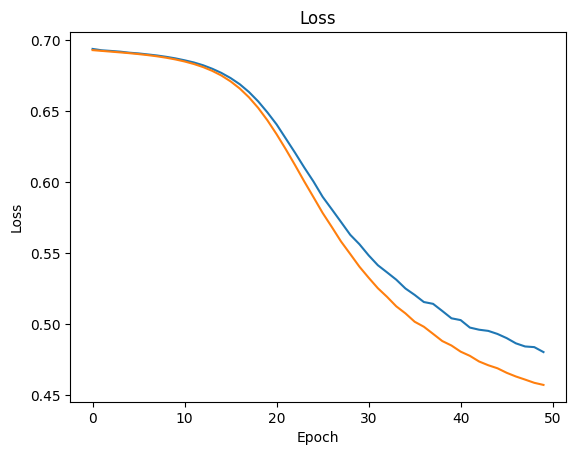

In [141]:
print("Accuracy of Simple FNN(a):", fnn_training_2a['accuracy']*100, "%")
plt.plot(fnn_training_2a['training'])
plt.plot(fnn_training_2a['validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### b) To generate the input features, concatenate the first 10 Word2Vec vectors for each review as the input feature (x = [WT1, ..., WT10]) and train the neural network. Report the accuracy value on the testing split for your MLP model. What do you conclude by comparing accuracy values you obtain with those obtained in the “’Simple Models” section.

In [50]:
def generate_concatenated_word_embeddings(reviews):
    word_embeddings = []
    for review in reviews:
        concatenated_vectors = []
        review_words = review.split(" ")

        for word in review_words[:10]:  # Take the first 10 words
            if word in w2v_model:
                concatenated_vectors.extend(w2v_model[word])

        # Pad with zeros if fewer than 10 words are available
        while len(concatenated_vectors) < 3000:
            concatenated_vectors.extend([0] * 300)

        word_embeddings.append(concatenated_vectors)

    return np.array(word_embeddings)
    

In [51]:
Xtrain_4_concatenated = generate_concatenated_word_embeddings(Xtrain)
Xtest_4_concatenated = generate_concatenated_word_embeddings(Xtest)

Xtrain_4_concatenated = Xtrain_4_concatenated.astype(np.float32)
Xtest_4_concatenated = Xtest_4_concatenated.astype(np.float32)

In [52]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        dataset = self.data[idx]
        class_label  = self.labels[idx]
        return dataset, class_label

batch_size = 32

train_dataset = CustomDataset(Xtrain_4_concatenated, Ytrain_4.values)
test_dataset = CustomDataset(Xtest_4_concatenated, Ytest_4.values)

validation_size = int(0.2*len(train_dataset))
training_size = len(train_dataset) - validation_size
train_set, val_set = random_split(train_dataset, [training_size, validation_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [53]:
class ConcatenatedMLPModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(ConcatenatedMLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Initialize the model
input_size = 300*10  # Word2Vec vector dimension
hidden_size1 = 50
hidden_size2 = 5
output_size = 2  # Replace num_classes with the number of classes in your classification task

model2b = ConcatenatedMLPModel(input_size, hidden_size1, hidden_size2, output_size)
print(model2b)

ConcatenatedMLPModel(
  (fc1): Linear(in_features=3000, out_features=50, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=50, out_features=5, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=5, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2b.parameters(), lr=0.01)

In [55]:
fnn_training_2b = training(train_loader, val_loader, test_loader, model2b, optimizer, criterion, 32, 'fnn2b')

Epoch: 1 	Training Loss: 0.685408 	Validation Loss: 0.664071
Epoch: 2 	Training Loss: 0.615873 	Validation Loss: 0.563397
Epoch: 3 	Training Loss: 0.562726 	Validation Loss: 0.532883
Epoch: 4 	Training Loss: 0.544973 	Validation Loss: 0.525989
Epoch: 5 	Training Loss: 0.533774 	Validation Loss: 0.522375
Epoch: 6 	Training Loss: 0.527566 	Validation Loss: 0.522683
Epoch: 7 	Training Loss: 0.519735 	Validation Loss: 0.517714
Epoch: 8 	Training Loss: 0.512608 	Validation Loss: 0.513660
Epoch: 9 	Training Loss: 0.503130 	Validation Loss: 0.514764
Epoch: 10 	Training Loss: 0.494494 	Validation Loss: 0.508468
Epoch: 11 	Training Loss: 0.482329 	Validation Loss: 0.509594
Epoch: 12 	Training Loss: 0.467641 	Validation Loss: 0.510186
Epoch: 13 	Training Loss: 0.453942 	Validation Loss: 0.516451
Epoch: 14 	Training Loss: 0.434467 	Validation Loss: 0.515967
Epoch: 15 	Training Loss: 0.415904 	Validation Loss: 0.523239
Epoch: 16 	Training Loss: 0.395739 	Validation Loss: 0.529037
Epoch: 17 	Traini

Accuracy of Simple FNN(b): 74.285 %


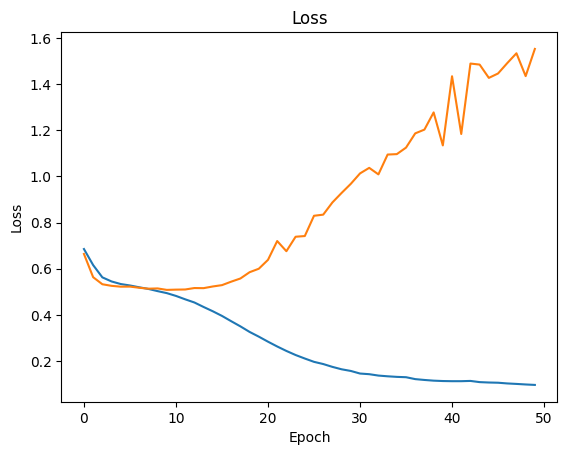

In [56]:
print("Accuracy of Simple FNN(b):", fnn_training_2b['accuracy']*100, "%")
plt.plot(fnn_training_2b['training'])
plt.plot(fnn_training_2b['validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 5) Recurrent Neural Networks

### a) Train a simple RNN for sentiment analysis. You can consider an RNN cell with the hidden state size of 10. To feed your data into our RNN, limit the maximum review length to 10 by truncating longer reviews and padding shorter reviews with a null value (0). Report accuracy values on the testing split for your RNN model.

In [65]:
def rnn_embedding_creation(data, max_words, wv_model):
    word_embeddings = []
    padding = np.zeros((1, 300))

    for rev in data:
        w2v_vector = []
        # Tokenize the review
        review_words = rev.split(" ")

        for word in review_words[:max_words]:
            if word in wv_model:
                w2v_vector.append(wv_model[word].reshape(1, -1))
            else:
                w2v_vector.append(padding)

        # Ensure the number of word vectors is equal to max_words
        while len(w2v_vector) < max_words:
            w2v_vector.append(padding)

        word_embeddings.append(w2v_vector)
        
    word_embeddings_arr = np.array(word_embeddings)

    return word_embeddings_arr

In [75]:
Xtrain_5 = rnn_embedding_creation(Xtrain, 10, w2v_model)
Xtest_5 = rnn_embedding_creation(Xtest, 10, w2v_model)
Xtrain_5_rnn = Xtrain_5.reshape(Xtrain_5.shape[0], Xtrain_5.shape[1], Xtrain_5.shape[3])
Xtest_5_rnn = Xtest_5.reshape(Xtest_5.shape[0], Xtest_5.shape[1], Xtest_5.shape[3])

Xtrain_5_rnn = Xtrain_5_rnn.astype(np.float32)
Xtest_5_rnn = Xtest_5_rnn.astype(np.float32)

Ytrain_5 = Ytrain.copy()
Ytest_5 = Ytest.copy()
Ytrain_5-=1
Ytest_5-=1

In [76]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        dataset = self.data[idx]
        class_label  = self.labels[idx]
        return dataset, class_label

batch_size = 32

train_dataset = CustomDataset(Xtrain_5_rnn, Ytrain_5.values)
test_dataset = CustomDataset(Xtest_5_rnn, Ytest_5.values)

validation_size = int(0.2*len(train_dataset))
training_size = len(train_dataset) - validation_size
train_set, val_set = random_split(train_dataset, [training_size, validation_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [77]:
class RNN(nn.Module):    
    def __init__(self, input_size, hidden_size, output_size, n_layers): 
        super(RNN, self).__init__()
        self.layer_dim = n_layers
        self.rnn = nn.RNN(input_size, hidden_size, n_layers, batch_first=True, nonlinearity='relu')
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), 10)
        out, _ = self.rnn(x, h0)
        return self.linear(out[:, -1, :])
    
input_size = 300
hidden_size = 10
output_size = 2
n_layers = 2

rnn = RNN(input_size, hidden_size, output_size, n_layers)
print(rnn)

RNN(
  (rnn): RNN(300, 10, num_layers=2, batch_first=True)
  (linear): Linear(in_features=10, out_features=2, bias=True)
)


In [78]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(rnn.parameters(), lr=0.01)

In [79]:
rnn_training = training(train_loader, val_loader, test_loader, rnn, optimizer, criterion, 32, 'rnn')

Epoch: 1 	Training Loss: 0.693833 	Validation Loss: 0.693439
Epoch: 2 	Training Loss: 0.692610 	Validation Loss: 0.692461
Epoch: 3 	Training Loss: 0.690687 	Validation Loss: 0.688948
Epoch: 4 	Training Loss: 0.684503 	Validation Loss: 0.679331
Epoch: 5 	Training Loss: 0.629651 	Validation Loss: 0.600354
Epoch: 6 	Training Loss: 0.571966 	Validation Loss: 0.563144
Epoch: 7 	Training Loss: 0.554655 	Validation Loss: 0.541020
Epoch: 8 	Training Loss: 0.543354 	Validation Loss: 0.537143
Epoch: 9 	Training Loss: 0.534916 	Validation Loss: 0.523732
Epoch: 10 	Training Loss: 0.528496 	Validation Loss: 0.522845
Epoch: 11 	Training Loss: 0.523683 	Validation Loss: 0.522802
Epoch: 12 	Training Loss: 0.519660 	Validation Loss: 0.527229
Epoch: 13 	Training Loss: 0.515958 	Validation Loss: 0.509381
Epoch: 14 	Training Loss: 0.512691 	Validation Loss: 0.506113
Epoch: 15 	Training Loss: 0.510417 	Validation Loss: 0.504447
Epoch: 16 	Training Loss: 0.507398 	Validation Loss: 0.500993
Epoch: 17 	Traini

Accuracy of RNN: 77.315 %


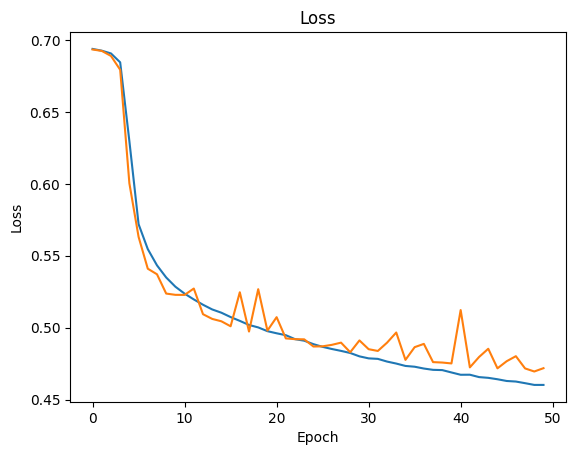

In [132]:
print("Accuracy of RNN:", rnn_training['accuracy']*100, "%")
plt.plot(rnn_training['training'])
plt.plot(rnn_training['validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### b) Repeat part (a) by considering a gated recurrent unit cell.

In [118]:
Xtrain_5 = rnn_embedding_creation(Xtrain, 10, w2v_model)
Xtest_5 = rnn_embedding_creation(Xtest, 10, w2v_model)
Xtrain_5_gru = Xtrain_5.reshape(Xtrain_5.shape[0], Xtrain_5.shape[1], Xtrain_5.shape[3])
Xtest_5_gru = Xtest_5.reshape(Xtest_5.shape[0], Xtest_5.shape[1], Xtest_5.shape[3])

Xtrain_5_gru = Xtrain_5_gru.astype(np.float32)
Xtest_5_gru = Xtest_5_gru.astype(np.float32)

Ytrain_5 = Ytrain.copy()
Ytest_5 = Ytest.copy()
Ytrain_5-=1
Ytest_5-=1

In [119]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        dataset = self.data[idx]
        class_label  = self.labels[idx]
        return dataset, class_label

batch_size = 32

train_dataset = CustomDataset(Xtrain_5_gru, Ytrain_5.values)
test_dataset = CustomDataset(Xtest_5_gru, Ytest_5.values)

validation_size = int(0.2*len(train_dataset))
training_size = len(train_dataset) - validation_size
train_set, val_set = random_split(train_dataset, [training_size, validation_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [120]:
class GRU(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, n_layers): 
        super(GRU, self).__init__()
        self.layer_dim = n_layers
        self.gru = nn.GRU(input_size, hidden_size, n_layers,batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

        
    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), 10)
        out, hn = self.gru(x, h0)
        return self.linear(out[:, -1, :])
    
input_size = 300
hidden_size = 10
output_size = 2
n_layers = 2

gru = GRU(input_size, hidden_size, output_size, n_layers)
print(gru)

GRU(
  (gru): GRU(300, 10, num_layers=2, batch_first=True)
  (linear): Linear(in_features=10, out_features=2, bias=True)
)


In [121]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(gru.parameters(), lr=0.01)

In [122]:
gru_training = training(train_loader, val_loader, test_loader, gru, optimizer, criterion, 32, 'gru')

Epoch: 1 	Training Loss: 0.683004 	Validation Loss: 0.672164
Epoch: 2 	Training Loss: 0.651423 	Validation Loss: 0.628557
Epoch: 3 	Training Loss: 0.598906 	Validation Loss: 0.577697
Epoch: 4 	Training Loss: 0.559740 	Validation Loss: 0.547181
Epoch: 5 	Training Loss: 0.540301 	Validation Loss: 0.533525
Epoch: 6 	Training Loss: 0.529425 	Validation Loss: 0.528273
Epoch: 7 	Training Loss: 0.521807 	Validation Loss: 0.517658
Epoch: 8 	Training Loss: 0.516185 	Validation Loss: 0.512980
Epoch: 9 	Training Loss: 0.511714 	Validation Loss: 0.508835
Epoch: 10 	Training Loss: 0.507537 	Validation Loss: 0.506916
Epoch: 11 	Training Loss: 0.504116 	Validation Loss: 0.502957
Epoch: 12 	Training Loss: 0.501032 	Validation Loss: 0.500428
Epoch: 13 	Training Loss: 0.498425 	Validation Loss: 0.499808
Epoch: 14 	Training Loss: 0.496008 	Validation Loss: 0.498428
Epoch: 15 	Training Loss: 0.493858 	Validation Loss: 0.505394
Epoch: 16 	Training Loss: 0.491895 	Validation Loss: 0.493482
Epoch: 17 	Traini

Accuracy of GRU: 77.625 %


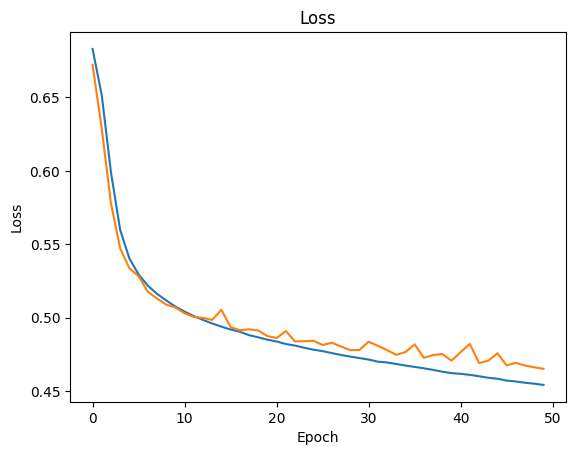

In [133]:
print("Accuracy of GRU:", gru_training['accuracy']*100, "%")
plt.plot(gru_training['training'])
plt.plot(gru_training['validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### c) Repeat part (a) by considering an LSTM unit cell

In [125]:
Xtrain_5 = rnn_embedding_creation(Xtrain, 10, w2v_model)
Xtest_5 = rnn_embedding_creation(Xtest, 10, w2v_model)
Xtrain_5_lstm = Xtrain_5.reshape(Xtrain_5.shape[0], Xtrain_5.shape[1], Xtrain_5.shape[3])
Xtest_5_lstm = Xtest_5.reshape(Xtest_5.shape[0], Xtest_5.shape[1], Xtest_5.shape[3])

Xtrain_5_lstm = Xtrain_5_lstm.astype(np.float32)
Xtest_5_lstm = Xtest_5_lstm.astype(np.float32)

Ytrain_5 = Ytrain.copy()
Ytest_5 = Ytest.copy()
Ytrain_5-=1
Ytest_5-=1

In [126]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        dataset = self.data[idx]
        class_label  = self.labels[idx]
        return dataset, class_label

batch_size = 32

train_dataset = CustomDataset(Xtrain_5_lstm, Ytrain_5.values)
test_dataset = CustomDataset(Xtest_5_lstm, Ytest_5.values)

validation_size = int(0.2*len(train_dataset))
training_size = len(train_dataset) - validation_size
train_set, val_set = random_split(train_dataset, [training_size, validation_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [127]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out
    
input_size = 300
hidden_size = 10
output_size = 2
num_layers = 2

lstm = LSTM(input_size, hidden_size, output_size, num_layers)
print(lstm)

LSTM(
  (lstm): LSTM(300, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=10, out_features=2, bias=True)
)


In [128]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(lstm.parameters(), lr=0.01)

In [129]:
lstm_training = training(train_loader, val_loader, test_loader, lstm, optimizer, criterion, 32, 'lstm')

Epoch: 1 	Training Loss: 0.692730 	Validation Loss: 0.692490
Epoch: 2 	Training Loss: 0.692280 	Validation Loss: 0.691958
Epoch: 3 	Training Loss: 0.691585 	Validation Loss: 0.691106
Epoch: 4 	Training Loss: 0.690317 	Validation Loss: 0.689299
Epoch: 5 	Training Loss: 0.687302 	Validation Loss: 0.684346
Epoch: 6 	Training Loss: 0.674679 	Validation Loss: 0.655378
Epoch: 7 	Training Loss: 0.615839 	Validation Loss: 0.589044
Epoch: 8 	Training Loss: 0.571081 	Validation Loss: 0.564727
Epoch: 9 	Training Loss: 0.550036 	Validation Loss: 0.543939
Epoch: 10 	Training Loss: 0.536859 	Validation Loss: 0.535250
Epoch: 11 	Training Loss: 0.527661 	Validation Loss: 0.526640
Epoch: 12 	Training Loss: 0.520778 	Validation Loss: 0.521053
Epoch: 13 	Training Loss: 0.515061 	Validation Loss: 0.519052
Epoch: 14 	Training Loss: 0.510257 	Validation Loss: 0.512942
Epoch: 15 	Training Loss: 0.506673 	Validation Loss: 0.513858
Epoch: 16 	Training Loss: 0.503489 	Validation Loss: 0.507105
Epoch: 17 	Traini

Accuracy of LSTM: 77.68 %


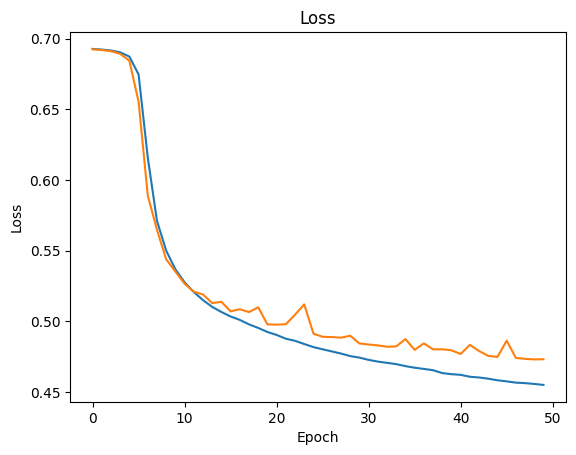

In [131]:
print("Accuracy of LSTM:", lstm_training['accuracy']*100, "%")
plt.plot(lstm_training['training'])
plt.plot(lstm_training['validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()